# MCMC/HMC Assignment

Metropolis-adjusted Langevin algorithm (MALA) sampler, is a variation of  Metropolis–Hastings (MH) sampler where the proposal state is generated as follows:
1. An auxiliary variable, $\mathbf{r}:= (r_1, \ldots, r_n)^\top$,
is drawn from an $n$ dimensional standard normal distribution where $n$ is the dimensinality of the target density function, $\pi(\mathbf{x})$:
$$\mathbf{r} \sim \mathcal{N}(\mathbf{0}_n, \mathbf{I}_{n\times n})$$ 
2. The proposal vector, $\mathbf{x}'$ is a deterministic function of the current state, $\mathbf{x}$, and the auximilary vector, $\mathbf{r}$:
$$
\mathbf{x}' := \mathbf{x} + \frac{\epsilon^2}{2} \cdot 
\frac{\partial \log \left(\pi(\mathbf{x})\right)}{\partial \mathbf{x}}
+ \epsilon \cdot \mathbf{r}
$$
where the step size, $\epsilon$, is a tunable hyper-parameter. 

## Assigment
(a) In this sampler, what is the MH proposal density fuction, $q(\mathbf{x}' | \mathbf{x})$?

(b) Is the proposal distribution symmetric i.e. is $q(\mathbf{x}' | \mathbf{x})$ equal to $q(\mathbf{x} | \mathbf{x}')$?

(c) Implement MALA sampler and use it to draw 10,000 samples from the experimental target density fuction $\texttt{SimGaussianMixture}$.

(d) Plot the samples. 


### 1. Target density models:  

## Solution:
(a) Let the the proposal $\mathbf{x}'$ be written as,

$$\mathbf{x}' = \bar{\mathbf{x}} + \epsilon \cdot \mathbf{r}$$

where $\mathbf{r} \sim \mathcal{N}(\mathbf{0}_n, \mathbf{I}_{n\times n})$ and, 

$$\bar{\mathbf{x}}=\mathbf{x} + \mathbf{x} + \frac{\epsilon^2}{2} \cdot 
\frac{\partial \log \left(\pi(\mathbf{x})\right)}{\partial \mathbf{x}}
$$

We can say that,
$$\mathbf{x}' \sim \mathcal{N}(\bar{\mathbf{x}}, \epsilon \cdot \mathbf{I}_{n\times n})$$

Therefore,

$$q(\mathbf{x}' | \mathbf{x}) = \frac{1}{\sqrt{2 \pi \epsilon}} \exp \bigg[ -\frac{(\mathbf{x}' - \bar{\mathbf{x}})^2}{\sqrt{2\epsilon}}\bigg]$$


(b) No, the proposal distribution is not symmetric. Due to the addition of the gradient term the value of $q(\mathbf{x}' | \mathbf{x})$ is **NOT** equal to $q(\mathbf{x} | \mathbf{x}')$

In [4]:
"""
Created by Created by Hadi Afshar. 
03/03/21
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import collections
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

class Model:
    def u(self, x):
        return -np.log(self.pr(x))

    def pr(self, x):
        raise  

    def grad_u(self, x):
        raise 




In [5]:
class MultivariateNormal(Model):
    def __init__(self, mean, variance):
        self.mean = mean
        self.dim = mean.shape[0]
        self.variance = variance

    def pr(self, x):
        z = x - self.mean
        return np.exp(-(1. / (2.0 * self.variance)) * z.dot(z))

    def grad_u(self, x):
        return (1./self.variance) * (x - self.mean) 
  

class SimGaussianMixture(Model):
    def __init__(self, O, radius, variance):
        self.O = O
        self.dim = O.shape[0]
        self.variance = variance

        self.centers = list()
        for i in range(self.dim):
            z = np.zeros(self.dim)
            z[i] = radius
            self.centers.append(MultivariateNormal(mean=O + z, variance=self.variance))
            self.centers.append(MultivariateNormal(mean=O - z, variance=self.variance))

    def pr(self, x):
        out = 0
        for c in self.centers:
            out += c.pr(x)
        return out / len(self.centers)

    def grad_u(self, x):
        out = 0
        for c in self.centers:
            out += c.grad_u(x)
        return out



### 2. MALA sampler
Complete the following code


In [6]:
class Sampler(object):
    def generate_sample(self, current_sample):
        raise


class MalaSampler(Sampler):
    def __init__(self, model, epsilon):
        self.model = model
        self.epsilon = epsilon

    def logq(self, x, x_bar):
        return stats.multivariate_normal(x_bar, cov=self.epsilon*np.eye(len(x))).logpdf(x)

    def generate_sample(self, current_x):
        ## you should complete this part... 
        ## by computing the MH log acceptance probability according to MALA proposal density
        
        # TODO
        r = np.random.randn(current_x.shape[0])
        current_x_bar = current_x + 0.5 * np.power(self.epsilon, 2) * self.model.grad_u(current_x) 

        proposal_x = current_x_bar + self.epsilon * r
        proposal_x_bar = proposal_x + 0.5 * np.power(self.epsilon, 2) * self.model.grad_u(proposal_x) 

        # Evaluate acceptance prob
        delta_logp = -(self.model.u(proposal_x) - self.model.u(current_x))
        
        delta_logq = self.logq(current_x, proposal_x_bar) - self.logq(proposal_x, current_x_bar)

        log_accept = min(1, np.exp(delta_logp + delta_logq))

        if np.random.uniform(low=0, high=1) < np.exp(log_accept):
            return proposal_x
        else:
            return current_x



The following code can be used to draw samples using MalaSampler and plotting them:

In [7]:
def generate_samples(sampler, init_sample, number_of_samples):
    current_sample = init_sample
    dim = current_sample.shape[0]

    samples = np.zeros(shape=(number_of_samples, dim), dtype=float)

    for sample_id in tqdm(range(0, number_of_samples)):
        current_sample = sampler.generate_sample(current_sample)
        samples[sample_id] = current_sample

    return samples

def plot_samples():
    B = 3
    C = 0.1  
    dim = 2
    x, y = np.mgrid[-B:B:C, -B:B:C]

    # model = MultivariateNormal(mean=np.array([0.0, 0.0]), variance=1.)
    model = SimGaussianMixture(O=np.zeros(dim), radius=1.0, variance=0.5)


    @np.vectorize
    def func(x, y):
        a = np.zeros(dim)
        a[0] = x
        a[1] = y
        return model.pr(a)


    z = func(x, y)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.contourf(x, y, z)

    sampler = MalaSampler(model=model, epsilon=0.1)
    samples = generate_samples(sampler=sampler, init_sample=np.ones(dim), number_of_samples=10000)

    # omit samples that are outside the mesh
    for i in range(samples.shape[0]):
        x = samples[i][0]
        y = samples[i][1]
        if x > B or y > B or x < -B or y < -B:
            samples[i] = None

    ax.scatter(x=samples[:, 0], y=samples[:, 1], color='black', marker='.', alpha=0.1)

    plt.show()



  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_4156/2758388065.py:20: RuntimeWarning: divide by zero encountered in log
  return -np.log(self.pr(x))
/tmp/ipykernel_4156/1439430665.py:26: RuntimeWarning: invalid value encountered in double_scalars
  delta_logp = -(self.model.u(proposal_x) - self.model.u(current_x))
 90%|████████▉ | 8975/10000 [00:05<00:00, 1675.65it/s]/home/arpitk/miniconda3/envs/std/lib/python3.9/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/arpitk/miniconda3/envs/std/lib/python3.9/site-packages/scipy/stats/_multivariate.py:467: RuntimeWarning: overflow encountered in square
  maha = np.sum(np.square(np.dot(dev, prec_U)), axis=-1)
100%|██████████| 10000/10000 [00:06<00:00, 1660.43it/s]


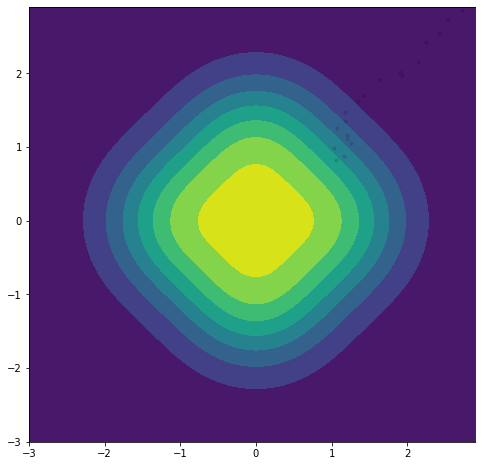

In [8]:
plot_samples()